In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Lib and Def Func

In [8]:
import pandas as pd
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_fscore_support, \
    confusion_matrix
import torch
import time
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# read and write model to pickle
def write_to_pickle(Pkl_File_path,model):
  with open(Pkl_File_path, 'wb') as file:  
      pickle.dump(model, file)

def read_pickle_model(path):
  with open(path, 'rb') as file:  
      return pickle.load(file)

In [10]:
# compute model scores
def compute_metrics(pred,ground_labels):
    labels_all = ground_labels
    preds_all = [round(value) for value in  list(pred)]
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, preds_all)
    acc = accuracy_score(labels_all, preds_all)
    confusion_mat = confusion_matrix(labels_all, preds_all)
    # tn, fp, fn, tp = confusiton_mat.ravel()
    out_dict = {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusiton_mat': confusion_mat
      }
    return out_dict

In [11]:
# mapping of the labels to 0,1 
def label_map(x): 
  if x in ['true', 'mostly-true', 'half-true', 'real', 'Real', 0, 'REAL']:
    return 0
  elif x in ['false', 'pants-fire', 'barely-true', 'fake', 'Fake', 1, 'FAKE']:
    return 1
  else:return x

In [12]:
# ~ 4-5 min run 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import xgboost as xgb

def compare_models( X_train, X_val, y_train, y_val,features,key):
  cla_pred=[]


  classifiers=[
             ['Logistic Regression',LogisticRegression()],
       ['Decision Tree Classification',DecisionTreeClassifier()],
       ['Gradient Boosting Classification', GradientBoostingClassifier()],
       ['Ada Boosting Classification',AdaBoostClassifier()],
       ['Extra Tree Classification', ExtraTreesClassifier(n_estimators=300)],
       ['K-Neighbors Classification',KNeighborsClassifier()],
       ['Support Vector Classification',SVC()],
       ['Gaussian Naive Bayes',GaussianNB()],
       ["xgBoost",xgb.XGBClassifier()]
  ]

  # print("Summary\n Class 0- True news \n Class 1 - False news\n {:}".format(key))
  # print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct
  
  for name,model1 in classifiers:
      # print("-----------"+name+"-------------")
      model1.fit(X_train[features],y_train)
      predicted_y = model1.predict(X_val[features])
      d=compute_metrics(predicted_y,y_val)
      cla_pred.append(d)
      write_to_pickle(outputDirectory+key+"_"+name+".pkl",model1)

      tn, fp, fn, tp = d["confusiton_mat"].ravel() #correct
      print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,key,name))

      dfCm=[key,name,d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp]
      results.append(dfCm)


  #Prining the evaluation matrix to the console
  # for i in range(len(classifiers)):
  #   d=cla_pred[i]
  #   tn, fp, fn, tp = cla_pred[i]["confusiton_mat"].ravel() #correct
  #   print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,classifiers[i][0]))

  #   dfCm=[key,classifiers[i][0],d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp]
  #   results.append(dfCm)

In [13]:
def normalize(dataFrame,features , parameterDict={}):
  dataframe=dataFrame.copy()
  for column in dataframe[features].columns.tolist():
    Q1=dataframe[column].quantile(0.25)
    Q3=dataframe[column].quantile(0.75)
    # Q1=parameterDict[column]["Q1"]
    # Q3=parameterDict[column]["Q3"]
    IQR=(Q3-Q1)
    minV=Q1 - 1.5*IQR
    maxV=Q3 + 1.5*IQR

    # IQR=parameterDict[column]["IQR"]
    # minV=parameterDict[column]["minV"]
    # maxV=parameterDict[column]["maxV"]

    temp=dataframe[column].copy()
  
    if ( column not in ["qn_symbol_per_sentence" , "num_exclamation_per_sentence" ,"lexical_diversity" ,"url_count_per_sentence"] ) :
      dataframe[column]=dataframe[column].apply(lambda x:minV if x< minV else maxV if x>maxV else x)

      mean = dataframe[column].mean()
      std  = dataframe[column].std()
      # mean=parameterDict[column]["mean"]
      # std=parameterDict[column]["std"]
      try:
        dataframe[column]=dataframe[column].apply(lambda x:  (x-mean)/std )
      except:
        print(column)
      # if ( dataframe[column].std()==0):
      #   dataframe[column]=temp.apply(lambda x : x)
    else:
      dataframe[column]=dataframe[column].apply(lambda x : 1 if x>0 else 0)
      print("col",column)
  return dataframe

In [14]:
def predict_for_model(X_val, y_val,features,dataset_name,model,model_name):
  # print("-----------"+model_name+"-------------")
    predicted_y = model.predict(X_val[features])
    score=compute_metrics(predicted_y,y_val)

    #Prining the evaluation matrix to the console
    d=score
    predictionScore.append(d)
    tn, fp, fn, tp = d["confusiton_mat"].ravel() #correct
    print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,dataset_name,model_name))

## rfecV

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

def rfecv(X_train, X_val, y_train, y_val,key,results):

  sementic_pipeline = Pipeline([
        ('trans', sementic_ct),
        ('clf', model_sementic_pipeline)
        ]
  )
  LangMod_embd_pipeline = Pipeline([
    ('trans', Lang_ct_embed_ct),
    ('clf', model_LangMod_emd_pipeline )
    ]
  )
  emotion_pipeline = Pipeline([
    ('trans', Sentiment_ct),
    ('clf', model_emotion_pipeline)
    ]
  )
  
  
  estimators = [
    ('sementicP', sementic_pipeline),
    ('lexP_embd', LangMod_embd_pipeline),
    ("emotionP" ,emotion_pipeline )
  ]

  voting="hard"
  clf =VotingClassifier(estimators=estimators ,voting=voting) 
  clf=ExtraTreesClassifier()
  rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
  rfecv.fit(X_train, y_train)

  print("Optimal number of features : %d" % rfecv.n_features_)

  plt.figure(figsize=(5,5))
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (nb of correct classifications)")
  plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
  plt.show()

  print(X_train.columns.values[rfecv.support_])
  rfecv_features=list(X_train.columns.values[rfecv.support_])
  print(len(rfecv_features)," : " ,rfecv_features)

  predicted_y = rfecv.predict(X_val)
  gg=compute_metrics(predicted_y,y_val)
  d=gg
  tn, fp, fn, tp = d["confusiton_mat"].ravel()
  # tn, fp, fn, tp = 0,0,0,0
  print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp'))  # correct
  print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp))
  
  # dfrfecv=pd.DataFrame([[key,"rfecv",d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp]],columns=resultsColumns)
  dfrfecv=[key,"rfecv",d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp]
  results.append(dfrfecv)
  return(rfecv_features)

# Define global varibles

In [15]:
# set All_features value to be used by the models 
sementic_features= [
                    'url_count', #
                    'qn_symbol', #
                    'num_chars', #
                    'num_words', #
                    'num_sentences', #
                    'num_exclamation', #

                    'words_per_sentence',  
                    'characters_per_word',
                    'punctuations_per_sentence', 
                    'get_sentiment_polarity',  
                    'lexical_diversity',
                    'content_word_diversity',
                    'redundancy',
                    'noun',
                    'verb',
                    'adj',
                    'adv',
                    "qn_symbol_per_sentence",
                    "num_exclamation_per_sentence",
                    "url_count_per_sentence"
                    ]

LangMod_Features=   [
                    #  'fake_score', 
                    # 'true_score', 
                     'fake_score1', 
                    'true_score1', 
                     'fake_score2', 
                    'true_score2', 
                    # 'common_score'
                    ]

Sentiment_features= [
                    #  'highest_eight_label', 
                    'anger', 
                    'anticipation',
                    'disgust', 
                    'fear',
                    'joy', 
                    'sadness', 
                    'surprise', 
                    'trust'
                    ]
embed_features= ["embd_true","embd_fake"]

All_features=sementic_features
# +LangMod_Features+Sentiment_features+embed_features

**VERIFY THE OUTPUT DIRECTORY AND FEATURE INPUT DIRECTORY PATHS BEFORE EXECUTING**

---



In [21]:
# set output directory for the models generated 
outputDirectory="/content/model/"
!mkdir model

### OLD

In [ ]:
# # input path of the feature set
# # -----------------------------

# inputPath={
#     "codalab":["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/CodaLab Covid/CodaLab_lexicon.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/CodaLab Covid/CodaLab_sementic.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/CodaLab Covid/CovidCodeLab_predictions_emotions.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/CodaLab Covid/CodaLab Covid_embedding.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/CodaLab Covid/Constraint_English_All.csv"],
#     "fakenewsnet" :["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_lexicon.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_sementic.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_predictions_emotions.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/FakeNewsNet/FakeNewsNet_embedding.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/FakeNewsNet/FakeNewsNet_All.csv"],
#     "isot":["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/ISOT/ISOT_lexicon.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/ISOT/ISOT_sementic.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/ISOT/ISOT_predictions_emotions.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/ISOT/ISOT_embedding.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/ISOT/ISOT.csv"],
#     # "kaggle" :["","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Kaggle/Kaggle_sementic.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Kaggle/Kaggle_predictions_emotions.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/Kaggle/Kaggle.csv"],
#     "kagglerealfake":["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Kaggle_real_fake/Kaggle_real_fake_lexicon.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Kaggle_real_fake/Kaggle_real_fake_sementic.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Kaggle_real_fake/Kaggle_real_fake_predictions_emotions.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/Kaggle_real_fake/Kaggle_real_fake_embedding.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/Kaggle_real_fake/fake_or_real_news.csv"],
#     "liar":["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/Liar_lexicon.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/Liar_sementic.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/LIAR_predictions_emotions.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/LIAR/LIAR_embedding.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/LIAR/Liar_all.csv"],
#     # "politifact":["","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Politifact/Politifact_sementic.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Politifact/Politifact_predictions_emotions.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/Politifact/Politifact.tsv"],
#     # "welfake":["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Welfake/Welfake_lexicon.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Welfake/Welfake_sementic.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Welfake/WelFake_emotion.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/Welfake/Welfake_embedding.csv","/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/WelFake/WELFake.csv"]
# }

### NEW 

In [16]:
# input path of the feature set
# -----------------------------

inputPath={
    "codalab":[
               "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/CodaLab Covid/CodaLab_with_WELFAKE_Lexicon_Scores.csv",
               "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/CodaLab Covid/CodaLab Covid_sementic.csv",
               "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/CodaLab Covid/Codalab_emotion_scores_modified.csv",
               "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/CodaLab Covid/CodaLab Covid_embedding.csv",
               "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/CodaLab Covid/Constraint_English_All.csv"],
    
    "fakenewsnet" :["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_with_WELFAKE_Lexicon_Scores.csv",
                    "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_sementic.csv",
                    "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/FakeNewsNet/FakeNewsNet_emotion_scores_modified.csv",
                    "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/FakeNewsNet/FakeNewsNet_embedding.csv",
                    "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/FakeNewsNet/FakeNewsNet_All.csv"],
           
    "isot":["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/ISOT/ISOT_with_WELFAKE_Lexicon_Scores.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/ISOT/ISOT_sementic.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/ISOT/ISOT_emotion_scores_modified.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/ISOT/ISOT_embedding.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/ISOT/ISOT.csv"],
           
    "kagglerealfake":["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Kaggle_real_fake/Kaggle_real_fake_with_WELFAKE_Lexicon_Scores.csv",
                      "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Kaggle_real_fake/Kaggle_real_fake_sementic.csv",
                      "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Kaggle_real_fake/Kaggle_real_fake_emotion_scores_modified.csv",
                      "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/Kaggle_real_fake/Kaggle_real_fake_embedding.csv",
                      "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/Kaggle_real_fake/fake_or_real_news.csv"],
    
    "liar":["/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/Liar_with_WELFAKE_Lexicon_Scores.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/LIAR_sementic.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/LIAR/LIAR_emotion_scores_modified.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Final/LIAR/LIAR_embedding.csv",
            "/content/drive/Shareddrives/[FYP] Fake News Detection/Datasets/LIAR/Liar_all.csv"],
}

In [ ]:
# !rm -fr model2
# !mkdir model2

WARNING compare_models funtion will write the model to the resutls folder 
---
---

In [17]:
id={"codalab":"id", "fakenewsnet":"id_1", "isot":"id", "kaggle":"id","kagglerealfake":"id", "liar":"ID", "politifact":"claim_id", "welfake":"id"}
label={"codalab":"label", "fakenewsnet":"label", "isot":"label", "kaggle":"label","kagglerealfake":"label","liar":"label", "politifact":"cred_label", "welfake":"label"}
features=["lexicon","sementic","sentiment","embedding"]
text_column={"codalab":"tweet", "fakenewsnet":"title", "isot":"text", "kaggle":"text","kagglerealfake":"text", "liar":"statement", "politifact":"text", "welfake":"text"}

In [38]:
## load all data set in to a dataframe dictionary (UPDATE :not  NORMALIZED)
all_df={}
parameterDict={}
for key,value in inputPath.items():
  print("----------",key,"--------------")
  error=False
  ID=id[key]
  TEXT=text_column[key]
  Label=label[key]

  for v in range(4):
    if value[v]=="":
      error=True
      print("   Error: missing {:} skipping {:}".format(features[v],key))
      break
  if (not error):
    dfLexicon  = pd.read_csv(value[0])
    dfSementic = pd.read_csv(value[1])
    dfSentiment = pd.read_csv(value[2])
    dfEmbedding = pd.read_csv(value[3])

    dff=dfSentiment.merge(dfSementic, how='inner', on=ID,suffixes=('_Sentiment', '_Sementic'))
    dff=dff.merge(dfLexicon, how='inner', on=ID,suffixes=('', '_Lexicon'))
    df=dff.merge(dfEmbedding, how='inner', on=ID,suffixes=('', '_Lexicon'))

    df=df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)

    # df["qn_symbol_per_sentence"]=df["qn_symbol"]/df["num_sentences"]
    # df["num_exclamation_per_sentence"]=df["num_exclamation"]/df["num_sentences"]
    # df["url_count_per_sentence"]=df["url_count"]/df["num_sentences"]

    df["scores"]=df["scores"].apply(lambda x : list(map(np.float64, x.strip('][').replace('"', '').replace("'","").replace(" ","").split(','))))
    # df["fake_score"]=df["scores"].apply(lambda x:x[0])
    # df["true_score"]=df["scores"].apply(lambda x:x[1])

    df["fake_score1"]=df["scores"].apply(lambda x:x[2])
    df["true_score1"]=df["scores"].apply(lambda x:x[3])

    df["fake_score2"]=df["scores"].apply(lambda x:x[4])
    df["true_score2"]=df["scores"].apply(lambda x:x[5])

    df=df.loc[df["lang"]=="en"]
    df["label"]=df[Label+"_Sementic"]

    print(df["label"].value_counts())

    df["label"]=df["label"].apply(label_map)
    # print(df["label"].value_counts())
    
    if (key=="codalab" or key=="liar"):  
      df=df[All_features+["label",ID,"split_Sementic"]]
    else :
      df=df[All_features+["label",ID,]]
      

    print("null rows : ",df.isnull().any(axis=1).sum())
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("inf rows : ",df.isnull().any(axis=1).sum())
    df.dropna(inplace=True)
    # new_df = df.groupby('label').apply(lambda x: x.sample(n=min(df["label"].value_counts().to_list()))).reset_index(drop = True)
    # print(new_df["label"].value_counts())

    # all_df[key]=normalize(df,All_features,parameterDict)
    all_df[key]=df.copy(deep=True)

    # print(df["label"].value_counts())

---------- codalab --------------
real    5583
fake    5037
Name: label, dtype: int64
null rows :  0
inf rows :  0
---------- fakenewsnet --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Real    16414
Fake     5301
Name: label, dtype: int64
null rows :  0
inf rows :  0
---------- isot --------------
1    22724
0    21416
Name: label, dtype: int64
null rows :  0
inf rows :  0
---------- kagglerealfake --------------
REAL    3171
FAKE    3123
Name: label, dtype: int64
null rows :  0
inf rows :  0
---------- liar --------------
half-true      2616
false          2484
mostly-true    2444
barely-true    2093
true           2040
pants-fire     1032
Name: label, dtype: int64
null rows :  0
inf rows :  0


In [19]:
all_df.keys()

dict_keys(['codalab', 'fakenewsnet', 'isot', 'kagglerealfake', 'liar'])

In [ ]:
for key,value in all_df.items():
  print(value.describe())

In [ ]:
dfAll=all_df["isot"].append(all_df["liar"],ignore_index = True).append(all_df["kagglerealfake"],ignore_index = True).append(all_df["codalab"],ignore_index = True).append(all_df["fakenewsnet"],ignore_index = True)
# .append(all_df["welfake"],ignore_index = True)

In [ ]:
# dfAll.hist(figsize=(20,20), xrot=-45 ,bins=100)

In [ ]:
# from IPython.display import display, HTML
# # CSS = """
# # .output {
# #     flex-direction: row;
# # }
# # """

# # HTML('<style>{}</style>'.format(CSS))
# df_summary={}
# for key in dfAll:
#   print(key,"\n")
#   dis=dfAll[key].describe()
#   df_summary[key]=dis
#   display(dis)

In [39]:
# Train using all the features 

resultsColumns=["data","model",'prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp']
results=[]

print("Summary\n Class 0- True news \n Class 1 - False news\n")
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct


for key,value in all_df.items():
  # print("----------",key,"--------------")
  df = value
  if (key=="codalab" or key=="liar"):
    df_train = df.loc[df["split_Sementic"]=="train"][All_features+['label']]
    df_test = df.loc[df["split_Sementic"]!="train"][All_features+['label']]  

    X_train=df_train[All_features]
    y_train=df_train["label"]
    X_val=df_test[All_features]
    y_val=df_test["label"]
  else:
    X_train, X_val, y_train, y_val = train_test_split(df[All_features], df["label"], test_size=0.3, random_state=142,stratify=df["label"])
  
  # rfec_features=rfecv(X_train, X_val, y_train, y_val,key,results)

  # compare_models( X_train, X_val, y_train, y_val ,All_features,key)
  compare_models( X_train, X_val, y_train, y_val ,sementic_features,key+"_sementic")
  # compare_models( X_train, X_val, y_train, y_val ,LangMod_Features,key+"_LangMod")
  # compare_models( X_train, X_val, y_train, y_val ,Sentiment_features,key+"_Sentiment")
  # compare_models( X_train, X_val, y_train, y_val ,embed_features,key+"_embed")
  # compare_models( X_train, X_val, y_train, y_val ,LangMod_Features+embed_features,key+"_embed_and_LangMod")
  

Summary
 Class 0- True news 
 Class 1 - False news

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp	dataset	model
0.765	0.762	0.793	0.730	0.779	0.746	0.764	1771	461	544	1474	codalab_sementic	Logistic Regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.773	0.746	0.769	0.750	0.771	0.748	0.760	1717	515	505	1513	codalab_sementic	Decision Tree Classification
0.790	0.870	0.901	0.735	0.842	0.797	0.822	2010	222	535	1483	codalab_sementic	Gradient Boosting Classification
0.782	0.815	0.848	0.738	0.814	0.775	0.796	1893	339	528	1490	codalab_sementic	Ada Boosting Classification
0.811	0.883	0.909	0.766	0.857	0.821	0.841	2028	204	472	1546	codalab_sementic	Extra Tree Classification
0.752	0.779	0.820	0.702	0.785	0.738	0.764	1830	402	602	1416	codalab_sementic	K-Neighbors Classification
0.734	0.754	0.799	0.680	0.765	0.715	0.743	1783	449	645	1373	codalab_sementic	Support Vector Classification
0.566	0.780	0.950	0.195	0.710	0.312	0.592	2121	111	1625	393	codalab_sementic	Gaussian Naive Bayes
0.783	0.872	0.904	0.723	0.839	0.791	0.818	2018	214	559	1459	codalab_sementic	xgBoost


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.763	0.551	0.986	0.054	0.861	0.099	0.758	4855	70	1504	86	fakenewsnet_sementic	Logistic Regression
0.797	0.364	0.785	0.382	0.791	0.373	0.686	3864	1061	983	607	fakenewsnet_sementic	Decision Tree Classification
0.769	0.598	0.981	0.088	0.862	0.154	0.763	4831	94	1450	140	fakenewsnet_sementic	Gradient Boosting Classification
0.770	0.568	0.977	0.094	0.861	0.162	0.761	4811	114	1440	150	fakenewsnet_sementic	Ada Boosting Classification
0.792	0.582	0.946	0.231	0.863	0.331	0.772	4661	264	1222	368	fakenewsnet_sementic	Extra Tree Classification
0.773	0.375	0.905	0.176	0.834	0.240	0.727	4459	466	1310	280	fakenewsnet_sementic	K-Neighbors Classification


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.756	0.000	1.000	0.000	0.861	0.000	0.756	4925	0	1590	0	fakenewsnet_sementic	Support Vector Classification
0.772	0.461	0.952	0.126	0.852	0.198	0.751	4690	235	1389	201	fakenewsnet_sementic	Gaussian Naive Bayes
0.769	0.636	0.985	0.082	0.863	0.146	0.765	4850	75	1459	131	fakenewsnet_sementic	xgBoost


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.798	0.816	0.806	0.807	0.802	0.811	0.807	5181	1244	1314	5503	isot_sementic	Logistic Regression
0.871	0.848	0.832	0.884	0.851	0.865	0.858	5343	1082	793	6024	isot_sementic	Decision Tree Classification
0.844	0.889	0.888	0.845	0.865	0.866	0.866	5707	718	1058	5759	isot_sementic	Gradient Boosting Classification
0.826	0.877	0.877	0.825	0.851	0.850	0.850	5635	790	1191	5626	isot_sementic	Ada Boosting Classification
0.902	0.925	0.922	0.905	0.912	0.915	0.913	5924	501	647	6170	isot_sementic	Extra Tree Classification
0.712	0.770	0.777	0.704	0.743	0.736	0.739	4993	1432	2018	4799	isot_sementic	K-Neighbors Classification
0.607	0.607	0.540	0.670	0.571	0.637	0.607	3467	2958	2247	4570	isot_sementic	Support Vector Classification
0.625	0.929	0.963	0.456	0.758	0.611	0.702	6186	239	3710	3107	isot_sementic	Gaussian Naive Bayes
0.837	0.893	0.894	0.836	0.864	0.863	0.864	5741	684	1120	5697	isot_sementic	xgBoost
0.730	0.723	0.726	0.727	0.728	0.725	0.726	691	261	256	681	kagglerealfake_sementic	Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.708	0.698	0.700	0.707	0.704	0.702	0.703	666	286	275	662	kagglerealfake_sementic	Decision Tree Classification
0.770	0.763	0.766	0.767	0.768	0.765	0.767	729	223	218	719	kagglerealfake_sementic	Gradient Boosting Classification
0.746	0.767	0.782	0.730	0.763	0.748	0.756	744	208	253	684	kagglerealfake_sementic	Ada Boosting Classification
0.783	0.782	0.786	0.779	0.784	0.780	0.782	748	204	207	730	kagglerealfake_sementic	Extra Tree Classification
0.632	0.642	0.667	0.606	0.649	0.623	0.637	635	317	369	568	kagglerealfake_sementic	K-Neighbors Classification
0.617	0.612	0.621	0.608	0.619	0.610	0.615	591	361	367	570	kagglerealfake_sementic	Support Vector Classification
0.553	0.781	0.936	0.232	0.695	0.357	0.587	891	61	720	217	kagglerealfake_sementic	Gaussian Naive Bayes
0.766	0.769	0.775	0.760	0.771	0.764	0.768	738	214	225	712	kagglerealfake_sementic	xgBoost


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.565	0.557	0.854	0.218	0.680	0.314	0.563	1177	201	907	253	liar_sementic	Logistic Regression
0.563	0.480	0.557	0.485	0.560	0.483	0.524	768	610	597	563	liar_sementic	Decision Tree Classification
0.564	0.529	0.801	0.266	0.662	0.354	0.556	1104	274	852	308	liar_sementic	Gradient Boosting Classification
0.572	0.545	0.790	0.299	0.664	0.386	0.565	1088	290	813	347	liar_sementic	Ada Boosting Classification
0.573	0.523	0.727	0.355	0.641	0.423	0.557	1002	376	748	412	liar_sementic	Extra Tree Classification
0.559	0.481	0.612	0.426	0.584	0.452	0.527	844	534	666	494	liar_sementic	K-Neighbors Classification
0.543	0.500	0.993	0.009	0.702	0.017	0.543	1368	10	1150	10	liar_sementic	Support Vector Classification
0.555	0.599	0.944	0.099	0.699	0.170	0.558	1301	77	1045	115	liar_sementic	Gaussian Naive Bayes
0.565	0.531	0.799	0.270	0.662	0.358	0.557	1101	277	847	313	liar_sementic	xgBoost


In [41]:
models={}
baseModelPath="/content/model"
f="_sementic"
m="_Gaussian Naive Bayes.pkl"    #  _Gaussian Naive Bayes ; _Extra Tree Classification
predictionScore=[]
trained_models_path={
  "codalab":baseModelPath+"/codalab"+f+m,
  "fakenewsnet": baseModelPath+"/fakenewsnet"+f+m,
  "isot": baseModelPath+"/isot"+f+m,
  "kagglerealfake": baseModelPath+"/kagglerealfake"+f+m,
  "liar":baseModelPath+"/liar"+f+m,
}
# for key,value in trained_models_path.items():
#   Path =value
#   print(Path)
#   models[key]=read_pickle_model(Path)
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct

for key1,value1 in all_df.items():
  df = value1
  X_val=df[All_features]
  y_val=df["label"]
  for key2,value in trained_models_path.items(): 
    Path =value
    value2=read_pickle_model(Path)
    predict_for_model(X_val,y_val,All_features,key1,value2,key2)

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp	dataset	model
0.568	0.806	0.958	0.193	0.713	0.312	0.595	5349	234	4063	974	codalab			codalab
0.277	0.339	0.185	0.463	0.222	0.392	0.317	1035	4548	2703	2334	codalab			fakenewsnet
0.412	0.443	0.167	0.736	0.238	0.553	0.437	932	4651	1331	3706	codalab			isot
0.374	0.396	0.243	0.550	0.295	0.461	0.389	1356	4227	2265	2772	codalab			kagglerealfake
0.577	0.674	0.873	0.291	0.695	0.407	0.597	4873	710	3570	1467	codalab			liar
0.776	0.313	0.798	0.285	0.787	0.299	0.673	13105	3309	3790	1511	fakenewsnet			codalab
0.773	0.493	0.957	0.130	0.855	0.205	0.755	15708	706	4614	687	fakenewsnet			fakenewsnet
0.774	0.249	0.217	0.803	0.339	0.380	0.360	3569	12845	1043	4258	fakenewsnet			isot
0.788	0.271	0.477	0.603	0.594	0.374	0.507	7822	8592	2104	3197	fakenewsnet			kagglerealfake
0.782	0.284	0.623	0.463	0.694	0.352	0.584	10228	6186	2847	2454	fakenewsnet			liar
0.716	0.530	0.089	0.967	0.159	0.684	0.541	1912	19504	758	21966	isot			codalab
0.187	0.510	0.006	0.973	0.0

In [ ]:
# Train using all the features 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier

resultsColumns=["data","model",'prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp']
results=[]

print("Summary\n Class 0- True news \n Class 1 - False news\n")
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct


# read csv to dataframe dict
for key,value in all_df.items():
  # print("----------",key,"--------------")
  df = value
  if (key=="codalab" or key=="liar"):
    df_train = df.loc[df["split_Sementic"]=="train"][All_features+['label']]
    df_test = df.loc[df["split_Sementic"]!="train"][All_features+['label']]  

    X_train=df_train[All_features]
    y_train=df_train["label"]
    X_val=df_test[All_features]
    y_val=df_test["label"]
  else:
    X_train, X_val, y_train, y_val = train_test_split(df[All_features], df["label"], test_size=0.3, random_state=142,stratify=df["label"])
  

# column transforemers 
  sementic_ct = ColumnTransformer([("sementic","passthrough", sementic_features )])
  Lang_ct_embed_ct = ColumnTransformer([("lexicon","passthrough", LangMod_Features +embed_features)])
  Sentiment_ct = ColumnTransformer([("emotion","passthrough", Sentiment_features )])
  # embed_ct = ColumnTransformer([("embedding","passthrough", embed_features )])

  
  n_estimators=300
  # def model for each estimators
  model_sementic_pipeline =  ExtraTreesClassifier(n_estimators=n_estimators)
  model_LangMod_emd_pipeline =  ExtraTreesClassifier(n_estimators=n_estimators)
  model_emotion_pipeline = ExtraTreesClassifier(n_estimators=n_estimators)
  # model_embd_pipeline = ExtraTreesClassifier()
  # final_estimator=ExtraTreesClassifier()


# create pipeline 
  sementic_pipeline = Pipeline([
        ('trans', sementic_ct),
        ('clf', model_sementic_pipeline)
        ]
  )
  LangMod_embd_pipeline = Pipeline([
    ('trans', Lang_ct_embed_ct),
    ('clf', model_LangMod_emd_pipeline )
    ]
  )
  emotion_pipeline = Pipeline([
    ('trans', Sentiment_ct),
    ('clf', model_emotion_pipeline)
    ]
  )
  
  
  estimators = [
    ('sementicP', sementic_pipeline),
    ('lexP_embd', LangMod_embd_pipeline),
    ("emotionP" ,emotion_pipeline )
  ]
  voting="hard"
  final_classifier =VotingClassifier(estimators=estimators ,voting=voting) 
  final_classifier.fit(X_train, y_train)
  write_to_pickle(outputDirectory+key+"_"+"VotingClassifier_"+voting+".pkl",final_classifier)
  predicted_y= final_classifier.predict(X_val)
  d=compute_metrics(predicted_y,y_val)

  tn, fp, fn, tp = d["confusiton_mat"].ravel() #correct
  print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,key,"ExtraTree"+voting))

  # for key2,value2 in models.items(): 
  #   if (key==key2):
  #     predict_for_model_ensample(X_val,y_val,All_features,key,value2,key2)

  # print("=============================================================================")
  # print("=============================================================================")


Summary
 Class 0- True news 
 Class 1 - False news

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp	dataset	model
0.813	0.858	0.884	0.775	0.847	0.814	0.832	1973	259	454	1564	codalab	ExtraTreehard
0.778	0.798	0.990	0.125	0.871	0.215	0.779	4875	50	1392	198	fakenewsnet	ExtraTreehard
0.950	0.973	0.972	0.952	0.961	0.962	0.961	6244	181	330	6487	isot	ExtraTreehard
0.873	0.885	0.889	0.869	0.881	0.877	0.879	846	106	123	814	kagglerealfake	ExtraTreehard
0.576	0.567	0.814	0.289	0.675	0.383	0.574	1122	256	825	335	liar	ExtraTreehard


In [ ]:
# !rm -fr model2

In [ ]:
# voting="hard"

In [ ]:
models={}
baseModelPath="/content/model"

trained_models_path={
  "codalab":baseModelPath+"/codalab",
  "fakenewsnet": baseModelPath+"/fakenewsnet",
  "isot": baseModelPath+"/isot",
  "kagglerealfake": baseModelPath+"/kagglerealfake",
  "liar":baseModelPath+"/liar",
}
# for key,value in trained_models_path.items():
#   Path =value+"_VotingClassifier_"+voting+ ".pkl"
#   print(Path)
#   models[key]=read_pickle_model(Path)

print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct

for key1,value1 in all_df.items():
  df = value1
  X_val=df[All_features]
  y_val=df["label"]
  for key2,value in trained_models_path.items():
    Path =value+"_VotingClassifier_"+voting+ ".pkl" 
    value2=read_pickle_model(Path)
    predicted_y= value2.predict(X_val)
    d=compute_metrics(predicted_y,y_val)

    tn, fp, fn, tp = d["confusiton_mat"].ravel() #correct
    print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,key1,key2))


In [ ]:
value2=read_pickle_model("/content/model/isot_VotingClassifier_hard.pkl")
value2.named_estimators_["sementicP"].steps[1][1].feature_importances_

array([0.05784836, 0.07643645, 0.06687705, 0.05006496, 0.        ,
       0.06345878, 0.06909116, 0.05647287, 0.04926822, 0.04575504,
       0.16515568, 0.16387961, 0.08945868, 0.04623314])

In [ ]:
value2.named_estimators_["emotionP"].steps[1][1]

ExtraTreesClassifier(n_estimators=300)

In [ ]:
value2

VotingClassifier(estimators=[('sementicP',
                              Pipeline(steps=[('trans',
                                               ColumnTransformer(transformers=[('sementic',
                                                                                'passthrough',
                                                                                ['words_per_sentence',
                                                                                 'characters_per_word',
                                                                                 'punctuations_per_sentence',
                                                                                 'get_sentiment_polarity',
                                                                                 'lexical_diversity',
                                                                                 'content_word_diversity',
                                                                                 

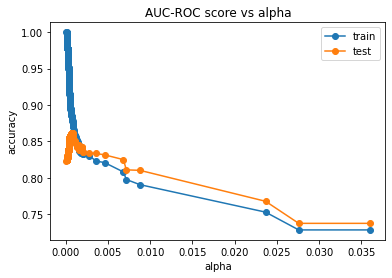

In [ ]:
# # Post pruning  https://towardsdatascience.com/3-techniques-to-avoid-overfitting-of-decision-trees-1e7d3d985a09
# clf = DecisionTreeClassifier(random_state=42)
# clf.fit(X_train, y_train)

# # compute ccp_alpha values
# path = clf.cost_complexity_pruning_path(X_train, y_train)
# ccp_alphas, impurities = path.ccp_alphas, path.impurities

# # train DT classifier for each ccp_alpha value
# clfs = []
# for ccp_alpha in ccp_alphas:
#     clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
#     clf.fit(X_train, y_train)
#     clfs.append(clf)

# # Plot train and test score for each of the above trained model    
# clfs = clfs[:-1]
# ccp_alphas = ccp_alphas[:-1]

# from sklearn.metrics import roc_auc_score
# train_scores = [roc_auc_score(y_train, clf.predict(X_train)) for clf in clfs]
# test_scores = [roc_auc_score(y_val, clf.predict(X_val)) for clf in clfs]

# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("AUC-ROC score vs alpha")
# ax.plot(ccp_alphas, train_scores, marker='o', label="train")
# ax.plot(ccp_alphas, test_scores, marker='o', label="test")
# ax.legend()
# plt.show()

In [ ]:
len(y_train)

198678

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(dfAll[All_features], dfAll["label"], test_size=0.3, random_state=142,stratify=dfAll["label"])
# compare_models( X_train, X_val, y_train, y_val ,All_features,"df_All")

0.966	0.983	0.986	0.960	0.976	0.972	0.974	49560	712	1733	41951	df_All	Extra Tree Classification


In [ ]:
baseModelPath="/content/model2"

trained_models_path={
# "codalab_ExtraTree":baseModelPath+"/codalab_Extra Tree Classification.pkl",
# "fakenewsnet_ExtraTree": baseModelPath+"/fakenewsnet_Extra Tree Classification.pkl",
# "isot_ExtraTree": baseModelPath+"/isot_Extra Tree Classification.pkl",
# "kagglerealfake_ExtraTree": baseModelPath+"/kagglerealfake_Extra Tree Classification.pkl",
# "liar_ExtraTree":baseModelPath+"/liar_Extra Tree Classification.pkl",
# "df_All":"/content/model2/df_All_Extra Tree Classification.pkl"
# "welfake_ExtraTree": baseModelPath+"/welfake_Extra Tree Classification.pkl",

# "codalab_XGBoost":baseModelPath+"/codalab_xgBoost.pkl",
# "fakenewsnet_XGBoost": baseModelPath+"/fakenewsnet_xgBoost.pkl",
# "isot_XGBoost": baseModelPath+"/isot_xgBoost.pkl",
# "kagglerealfake_XGBoost": baseModelPath+"/kagglerealfake_xgBoost.pkl",
# "liar_XGBoost":baseModelPath+"/liar_xgBoost.pkl",
# "welfake_XGBoost": baseModelPath+"/welfake_xgBoost.pkl"
}

# baseModelPath = "/content/drive/Shareddrives/[FYP] Fake News Detection/Final/model"

# trained_models_path = {
# "codalab":baseModelPath+"/codalab_stacking_Classifier_Extra_tree.pkl",
# "fakenewsnet": baseModelPath+"/fakenewsnet_stacking_Classifier_Extra_tree.pkl",
# "isot": baseModelPath+"/isot_stacking_Classifier_Extra_tree.pkl",
# "kagglerealfake": baseModelPath+"/kagglerealfake_stacking_Classifier_Extra_tree.pkl",
# "liar":baseModelPath+"/liar_stacking_Classifier_Extra_tree.pkl",
# # "welfake": baseModelPath+"/welfake_Extra Tree Classification.pkl"
# }


# trained_rfecv_models_path={
# "codalab":basePath+"/codalab_rfec_Extra Tree Classification.pkl",
# "fakenewsnet": basePath+"/fakenewsnet_rfec_Extra Tree Classification.pkl",
# "isot": basePath+"/isot_rfec_Extra Tree Classification.pkl",
# "kagglerealfake": basePath+"/kagglerealfake_rfec_Extra Tree Classification.pkl",
# "liar":basePath+"/liar_rfec_Extra Tree Classification.pkl",
# "welfake": basePath+"/welfake_rfec_Extra Tree Classification.pkl"
# }
# refec_features={
#   "codalab":['url_count', 'qn_symbol', 'num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 'punctuations_per_sentence', 'num_exclamation', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity', 'redundancy', 'noun', 'verb', 'adj', 'adv', 'qn_symbol_per_sentence', 'num_exclamation_per_sentence', 'url_count_per_sentence', 'fake_score', 'true_score', 'common_score', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'],
#   "fakenewsnet": ['num_chars', 'words_per_sentence', 'characters_per_word', 'punctuations_per_sentence', 'get_sentiment_polarity', 'content_word_diversity', 'redundancy', 'noun', 'verb', 'qn_symbol_per_sentence', 'fake_score', 'true_score', 'common_score', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'],
#   "isot":['url_count', 'qn_symbol', 'num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 'punctuations_per_sentence', 'num_exclamation', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity', 'redundancy', 'noun', 'verb', 'adj', 'adv', 'qn_symbol_per_sentence', 'num_exclamation_per_sentence', 'url_count_per_sentence'],
#   "kagglerealfake":  ['num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 'punctuations_per_sentence', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity', 'redundancy', 'noun', 'verb', 'adj', 'adv', 'qn_symbol_per_sentence', 'num_exclamation_per_sentence', 'url_count_per_sentence', 'fake_score', 'true_score', 'common_score', 'anger', 'anticipation', 'fear', 'joy', 'trust'],
#   "liar": ['num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 'punctuations_per_sentence', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity', 'redundancy', 'noun', 'verb', 'adj', 'adv', 'fake_score', 'true_score', 'common_score', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust'],
#   "welfake": ['url_count', 'qn_symbol', 'num_chars', 'num_words', 'num_sentences', 'words_per_sentence', 'characters_per_word', 'punctuations_per_sentence', 'num_exclamation', 'get_sentiment_polarity', 'lexical_diversity', 'content_word_diversity', 'redundancy', 'noun', 'verb', 'adj', 'adv', 'qn_symbol_per_sentence', 'num_exclamation_per_sentence', 'url_count_per_sentence', 'fake_score', 'true_score', 'common_score', 'anger', 'anticipation', 'trust']
# }



In [ ]:
models={}
baseModelPath="/content/model2"

trained_models_path={
  "codalab":baseModelPath+"/codalab",
  "fakenewsnet": baseModelPath+"/fakenewsnet",
  "isot": baseModelPath+"/isot",
  "kagglerealfake": baseModelPath+"/kagglerealfake",
  "liar":baseModelPath+"/liar",
}

for key,value in trained_models_path.items():
  print(value)
  submodels={}
  for i in ["_sementic","_LangMod","_Sentiment","_embed","_embed_and_LangMod"]:
    submodels[i]=read_pickle_model(value+i+"_Extra Tree Classification.pkl")
  models[key]=submodels

In [ ]:
models={}

for key,value in trained_models_path.items():
  print(value)
  models[key]=read_pickle_model(value)

/content/model2/codalab
/content/model2/fakenewsnet
/content/model2/isot
/content/model2/kagglerealfake
/content/model2/liar


In [ ]:
def predict_for_model_ensample(X_val, y_val,features,dataset_name,model,model_name):
  # print("-----------"+model_name+"-------------")
    predicted_y_sementic = model["_sementic"].predict(X_val[sementic_features])
    predicted_y_LangMod = model["_LangMod"].predict(X_val[LangMod_Features])
    predicted_y_Sentiment = model["_Sentiment"].predict(X_val[Sentiment_features])
    predicted_y_embed = model["_embed"].predict(X_val[embed_features])

    final_array=np.vstack((predicted_y_sementic,predicted_y_LangMod,predicted_y_Sentiment,predicted_y_embed)).T
    predicted_y=np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in final_array])
    score=compute_metrics(predicted_y,y_val)

    #Prining the evaluation matrix to the console
    d=score
    predictionScore.append(d)
    tn, fp, fn, tp = d["confusiton_mat"].ravel() #correct
    print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,dataset_name,model_name))
    
predictionScore=[]

print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct
for key1,value1 in all_df.items():
  df = value1
  X_val=df[All_features]
  y_val=df["label"]
  for key2,value2 in models.items(): 
      predict_for_model_ensample(X_val,y_val,All_features,key1,value2,key2)

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp	dataset			model
0.939	0.884	0.889	0.935	0.913	0.909	0.911	4964	619	325	4712	codalab			codalab
0.520	0.420	0.896	0.084	0.658	0.139	0.511	5002	581	4616	421	codalab			fakenewsnet
0.469	0.407	0.481	0.396	0.475	0.401	0.440	2684	2899	3044	1993	codalab			isot
0.616	0.496	0.224	0.845	0.329	0.625	0.519	1252	4331	779	4258	codalab			kagglerealfake
0.597	0.551	0.587	0.562	0.592	0.556	0.575	3277	2306	2208	2829	codalab			liar
0.797	0.259	0.361	0.709	0.497	0.379	0.444	5595	9923	1424	3463	fakenewsnet			codalab
0.919	0.933	0.984	0.725	0.950	0.816	0.922	15263	255	1343	3544	fakenewsnet			fakenewsnet
0.758	0.234	0.656	0.333	0.703	0.275	0.579	10180	5338	3258	1629	fakenewsnet			isot
0.764	0.241	0.291	0.714	0.421	0.360	0.392	4509	11009	1396	3491	fakenewsnet			kagglerealfake
0.781	0.261	0.533	0.525	0.633	0.349	0.531	8265	7253	2320	2567	fakenewsnet			liar
0.688	0.491	0.191	0.900	0.299	0.636	0.521	28969	122943	13138	118777	isot			codalab
0.547	0.744	0.980	0.0

In [ ]:
def predict_for_model_ensample(X_val, y_val,features,dataset_name,model,model_name):
  # print("-----------"+model_name+"-------------")
    predicted_y_sementic = model["_sementic"].predict(X_val[sementic_features])
    predicted_y_LangMod = model["_embed_and_LangMod"].predict(X_val[LangMod_Features+embed_features])
    predicted_y_Sentiment = model["_Sentiment"].predict(X_val[Sentiment_features])
    # predicted_y_embed = model["_embed"].predict(X_val[embed_features])

    final_array=np.vstack((predicted_y_sementic,predicted_y_LangMod,predicted_y_Sentiment)).T
    predicted_y=np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in final_array])
    score=compute_metrics(predicted_y,y_val)

    #Prining the evaluation matrix to the console
    d=score
    predictionScore.append(d)
    tn, fp, fn, tp = d["confusiton_mat"].ravel() #correct
    print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,dataset_name,model_name))
    
predictionScore=[]

print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct
for key1,value1 in all_df.items():
  df = value1
  X_val=df[All_features]
  y_val=df["label"]
  for key2,value2 in models.items(): 
      predict_for_model_ensample(X_val,y_val,All_features,key1,value2,key2)

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp	dataset			model
0.922	0.955	0.961	0.910	0.941	0.932	0.937	5365	218	453	4584	codalab			codalab
0.526	0.498	0.977	0.026	0.684	0.049	0.526	5452	131	4907	130	codalab			fakenewsnet
0.509	0.427	0.717	0.234	0.596	0.303	0.488	4004	1579	3858	1179	codalab			isot
0.585	0.501	0.344	0.730	0.433	0.594	0.527	1921	3662	1360	3677	codalab			kagglerealfake
0.569	0.630	0.847	0.288	0.681	0.395	0.582	4730	853	3586	1451	codalab			liar
0.789	0.278	0.595	0.495	0.679	0.356	0.571	9239	6279	2470	2417	fakenewsnet			codalab
0.916	0.988	0.997	0.708	0.955	0.825	0.928	15477	41	1427	3460	fakenewsnet			fakenewsnet
0.759	0.236	0.776	0.219	0.768	0.227	0.643	12043	3475	3816	1071	fakenewsnet			isot
0.767	0.246	0.521	0.498	0.620	0.330	0.515	8082	7436	2455	2432	fakenewsnet			kagglerealfake
0.774	0.281	0.771	0.283	0.772	0.282	0.654	11968	3550	3503	1384	fakenewsnet			liar
0.635	0.527	0.454	0.699	0.530	0.601	0.568	68989	82923	39644	92271	isot			codalab
0.541	0.782	0.992	0.031	

In [ ]:
def predict_for_model_ensample(X_val, y_val,features,dataset_name,model,model_name):
  # print("-----------"+model_name+"-------------")

  predicted_y_sementic = model["_sementic"].predict_proba(X_val[sementic_features])*5
  predicted_y_LangMod = model["_embed_and_LangMod"].predict_proba(X_val[LangMod_Features+embed_features])*3
  predicted_y_Sentiment = model["_Sentiment"].predict_proba(X_val[Sentiment_features])
  # predicted_y_embed=model["_embed"].predict_proba(X_val[embed_features])
 

  final_array=predicted_y_sementic+predicted_y_LangMod+predicted_y_Sentiment
  predicted_y=np.array([0 if row[0]> row[1]  else 1 for row in final_array])

  score=compute_metrics(predicted_y,y_val)

  #Prining the evaluation matrix to the console
  d=score
  predictionScore.append(d)
  tn, fp, fn, tp = d["confusiton_mat"].ravel() #correct
  print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,dataset_name,model_name))
    
predictionScore=[]

print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct
for key1,value1 in all_df.items():
  df = value1
  X_val=df[All_features]
  y_val=df["label"]
  for key2,value2 in models.items(): 
      predict_for_model_ensample(X_val,y_val,All_features,key1,value2,key2)

prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp	dataset			model
0.926	0.955	0.961	0.915	0.943	0.935	0.939	5367	216	427	4610	codalab			codalab
0.527	0.501	0.953	0.053	0.679	0.096	0.526	5318	265	4771	266	codalab			fakenewsnet
0.373	0.380	0.271	0.495	0.314	0.430	0.377	1515	4068	2543	2494	codalab			isot
0.354	0.405	0.194	0.608	0.250	0.486	0.390	1082	4501	1975	3062	codalab			kagglerealfake
0.569	0.596	0.796	0.333	0.664	0.427	0.576	4446	1137	3361	1676	codalab			liar
0.790	0.278	0.589	0.502	0.675	0.358	0.568	9147	6371	2435	2452	fakenewsnet			codalab
0.919	0.969	0.993	0.722	0.954	0.828	0.928	15405	113	1358	3529	fakenewsnet			fakenewsnet
0.764	0.245	0.618	0.394	0.683	0.302	0.564	9589	5929	2961	1926	fakenewsnet			isot
0.764	0.242	0.438	0.571	0.556	0.340	0.469	6790	8728	2097	2790	fakenewsnet			kagglerealfake
0.774	0.272	0.725	0.326	0.749	0.296	0.630	11256	4262	3296	1591	fakenewsnet			liar
0.643	0.510	0.357	0.771	0.459	0.614	0.549	54210	97702	30163	101752	isot			codalab
0.546	0.753	0.983	0.05

In [ ]:
predicted_y_sementic=models["codalab"]["_sementic"].predict_proba(X_val[sementic_features])
predicted_y_LangMod=models["codalab"]["_LangMod"].predict_proba(X_val[LangMod_Features])
predicted_y_Sentiment=models["codalab"]["_Sentiment"].predict_proba(X_val[Sentiment_features])
predicted_y_embed=models["codalab"]["_embed"].predict_proba(X_val[embed_features])

In [ ]:
final_array=np.vstack((predicted_y_sementic,predicted_y_LangMod,predicted_y_Sentiment,predicted_y_embed)).T
final_array

In [ ]:
final_array=predicted_y_sementic+predicted_y_LangMod+predicted_y_Sentiment+predicted_y_embed

In [ ]:
final_array

array([[1.17, 2.83],
       [2.81, 1.19],
       [2.3 , 1.7 ],
       ...,
       [1.96, 2.04],
       [1.75, 2.25],
       [2.1 , 1.9 ]])

In [ ]:
np.array([0 if row[0]> row[1]  else 1 for row in np.array([ [1,2],[2,1],[2,2]]) ])

array([1, 0, 1])

In [ ]:
np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in np.array([ [1,2],[2,1],[2,2] ] )])

array([2, 2, 2])

In [ ]:
from collections import Counter
most_f = np.array([Counter(sorted(row, reverse=True)).most_common(1)[0][0] for row in final_array])
most_f

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
predictionScore=[]
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct
for key1,value1 in all_df.items():
  df = value1
  # if (key=="codalab" or key=="liar"):
  #     df_test = df.loc[df["split_Sementic"]!="train"][All_features+['label']]  
  #     X_val=df_test[All_features]
  #     y_val=df_test["label"]
  # else:
  #   X_val=df[All_features]
  #   y_val=df["label"]

  X_val=df[All_features]
  y_val=df["label"]
  # print("=========="+key1+"===========")
  for key2,value2 in models.items(): 
    if (key1!=key2):
      predict_for_model(X_val,y_val,All_features,key1,value2,key2)


In [ ]:
## -- model using rfecV
# models_on_rfec_features={}
# for key,value in trained_rfecv_models_path.items():
#   models_on_rfec_features[key]=read_pickle_model(value)

In [ ]:
# dd=[]
# print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct
# for key1,value1 in all_df.items():
#   X_val=value1[All_features]
#   y_val=value1["label"]
#   print("=========="+key1+"===========")
#   for key2,value2 in models_on_rfec_features.items(): 
#     if (key1!=key2):
#       predict_for_model(X_val,y_val,refec_features[key2],key1,value2,key2+"_Extra_tree")


In [ ]:
results.to_csv("/content/drive/Shareddrives/[FYP] Fake News Detection/Results/Oct10FullRfecv.csv",index=False)

# normalize

In [ ]:
# dfRange={}
# for column in dfAll[All_features].columns.tolist():
#   Q1=dfAll[column].quantile(0.25)
#   Q3=dfAll[column].quantile(0.75)
#   IQR=(Q3-Q1)
#   minV=Q1 - 1.5*IQR
#   maxV=Q3 + 1.5*IQR
#   dfAll[column]=dfAll[column].apply(lambda x:minV if x< minV else maxV if x>maxV else x)
#   mean=dfAll[column].mean()
#   std=dfAll[column].std()
#   dfAll[column]=dfAll[column].apply(lambda x: 1 if (std==0 and x>0) else 0 if(std==0) else (x-mean)/std)
#   summaryDict={"Q1":Q1,"Q3":Q3,"IQR":IQR,"minV":minV,"maxV":maxV,"mean":mean,"std":std}
#   dfRange[column]=summaryDict

# dfRange

# parameterDict={'adj': {'IQR': 2.3188405797101463,
#   'Q1': 4.3478260869565215,
#   'Q3': 6.666666666666668,
#   'maxV': 10.144927536231886,
#   'mean': 5.464411372449828,
#   'minV': 0.869565217391302,
#   'std': 2.2154021619758604},
#  'adv': {'IQR': 2.365779135748582,
#   'Q1': 1.7721518987341771,
#   'Q3': 4.137931034482759,
#   'maxV': 7.686599738105632,
#   'mean': 2.9968552027163384,
#   'minV': -1.776516804888696,
#   'std': 1.9580813322883837},
#  'anger': {'IQR': 0.05850000000000001,
#   'Q1': 0.013999999999999999,
#   'Q3': 0.07250000000000001,
#   'maxV': 0.16025000000000003,
#   'mean': 0.05355639484360496,
#   'minV': -0.07375000000000002,
#   'std': 0.05383768863999539},
#  'anticipation': {'IQR': 0.023,
#   'Q1': 0.001,
#   'Q3': 0.024,
#   'maxV': 0.0585,
#   'mean': 0.016674754112556447,
#   'minV': -0.0335,
#   'std': 0.021419461745172612},
#  'characters_per_word': {'IQR': 0.45989960056295853,
#   'Q1': 4.721495748274251,
#   'Q3': 5.181395348837209,
#   'maxV': 5.871244749681647,
#   'mean': 4.958699560012415,
#   'minV': 4.031646347429813,
#   'std': 0.3778343377446481},
#  'common_score': {'IQR': 148.65181748926477,
#   'Q1': 31.620404784179648,
#   'Q3': 180.2722222734444,
#   'maxV': 403.24994850734157,
#   'mean': 128.96414099505745,
#   'minV': -191.35732144971752,
#   'std': 145.62458227217846},
#  'content_word_diversity': {'IQR': 11.588475267720547,
#   'Q1': 37.735849056603776,
#   'Q3': 49.32432432432432,
#   'maxV': 66.70703722590514,
#   'mean': 44.71834404664134,
#   'minV': 20.353136155022955,
#   'std': 10.040936904214178},
#  'disgust': {'IQR': 0.011,
#   'Q1': 0.001,
#   'Q3': 0.012,
#   'maxV': 0.0285,
#   'mean': 0.008739699468684827,
#   'minV': -0.0155,
#   'std': 0.010028646941583256},
#  'fake_score': {'IQR': 125.27662388259924,
#   'Q1': 33.07056670073225,
#   'Q3': 158.3471905833315,
#   'maxV': 346.26212640723037,
#   'mean': 115.45894576893151,
#   'minV': -154.84436912316662,
#   'std': 122.83526399361845},
#  'fear': {'IQR': 0.035,
#   'Q1': 0.006999999999999999,
#   'Q3': 0.042,
#   'maxV': 0.0945,
#   'mean': 0.029819809031689792,
#   'minV': -0.045500000000000006,
#   'std': 0.03270089978745751},
#  'get_sentiment_polarity': {'IQR': 1.7797,
#   'Q1': -0.8861,
#   'Q3': 0.8936,
#   'maxV': 3.5631500000000003,
#   'mean': 0.023991529123062672,
#   'minV': -3.55565,
#   'std': 0.7919547968009927},
#  'joy': {'IQR': 0.031000000000000003,
#   'Q1': 0.004,
#   'Q3': 0.035,
#   'maxV': 0.08150000000000002,
#   'mean': 0.024948415741532805,
#   'minV': -0.04250000000000001,
#   'std': 0.029254209051925974},
#  'lexical_diversity': {'IQR': 22.206663447609856,
#   'Q1': 52.105263157894726,
#   'Q3': 74.31192660550458,
#   'maxV': 107.62192177691936,
#   'mean': 64.53553870433639,
#   'minV': 18.795267986479942,
#   'std': 17.688132814730977},
#  'noun': {'IQR': 4.357631896898917,
#   'Q1': 12.56544502617801,
#   'Q3': 16.923076923076927,
#   'maxV': 23.459524768425304,
#   'mean': 14.905032116653095,
#   'minV': 6.028997180829633,
#   'std': 3.900651883996612},
#  'num_chars': {'IQR': 2497.0,
#   'Q1': 533.0,
#   'Q3': 3030.0,
#   'maxV': 6775.5,
#   'mean': 2151.904684937648,
#   'minV': -3212.5,
#   'std': 1793.8653349952872},
#  'num_exclamation': {'IQR': 0.0,
#   'Q1': 0.0,
#   'Q3': 0.0,
#   'maxV': 0.0,
#   'mean': 0.0,
#   'minV': 0.0,
#   'std': 0.0},
#  'num_exclamation_per_sentence': {'IQR': 0.0,
#   'Q1': 0.0,
#   'Q3': 0.0,
#   'maxV': 0.0,
#   'mean': 0.0,
#   'minV': 0.0,
#   'std': 0.0},
#  'num_sentences': {'IQR': 17.0,
#   'Q1': 3.0,
#   'Q3': 20.0,
#   'maxV': 45.5,
#   'mean': 14.15048390965971,
#   'minV': -22.5,
#   'std': 12.290476063100535},
#  'num_words': {'IQR': 416.0,
#   'Q1': 86.0,
#   'Q3': 502.0,
#   'maxV': 1126.0,
#   'mean': 355.58859617040855,
#   'minV': -538.0,
#   'std': 296.66670010690143},
#  'punctuations_per_sentence': {'IQR': 1.4705882352941178,
#   'Q1': 2.5294117647058822,
#   'Q3': 4.0,
#   'maxV': 6.205882352941177,
#   'mean': 3.2903360571876887,
#   'minV': 0.3235294117647056,
#   'std': 1.3598251378876491},
#  'qn_symbol': {'IQR': 0.0,
#   'Q1': 0.0,
#   'Q3': 0.0,
#   'maxV': 0.0,
#   'mean': 0.0,
#   'minV': 0.0,
#   'std': 0.0},
#  'qn_symbol_per_sentence': {'IQR': 0.0,
#   'Q1': 0.0,
#   'Q3': 0.0,
#   'maxV': 0.0,
#   'mean': 0.0,
#   'minV': 0.0,
#   'std': 0.0},
#  'redundancy': {'IQR': 9.396536263611054,
#   'Q1': 14.857988982498824,
#   'Q3': 24.25452524610988,
#   'maxV': 38.34932964152646,
#   'mean': 20.439464879603847,
#   'minV': 0.7631845870822431,
#   'std': 7.9938855660173935},
#  'sadness': {'IQR': 0.02,
#   'Q1': 0.004,
#   'Q3': 0.024,
#   'maxV': 0.054,
#   'mean': 0.017662777299320108,
#   'minV': -0.026,
#   'std': 0.018619414203816985},
#  'surprise': {'IQR': 0.009000000000000001,
#   'Q1': 0.001,
#   'Q3': 0.01,
#   'maxV': 0.0235,
#   'mean': 0.007281686152824013,
#   'minV': -0.0125,
#   'std': 0.008258791505317345},
#  'true_score': {'IQR': 175.9338021583739,
#   'Q1': 30.97202012652333,
#   'Q3': 206.90582228489723,
#   'maxV': 470.80652552245806,
#   'mean': 145.37698450435107,
#   'minV': -232.92868311103751,
#   'std': 172.08727191371233},
#  'trust': {'IQR': 0.043,
#   'Q1': 0.003,
#   'Q3': 0.046,
#   'maxV': 0.1105,
#   'mean': 0.0319873585729265,
#   'minV': -0.0615,
#   'std': 0.04057721593957883},
#  'url_count': {'IQR': 0.0,
#   'Q1': 0.0,
#   'Q3': 0.0,
#   'maxV': 0.0,
#   'mean': 0.0,
#   'minV': 0.0,
#   'std': 0.0},
#  'url_count_per_sentence': {'IQR': 0.0,
#   'Q1': 0.0,
#   'Q3': 0.0,
#   'maxV': 0.0,
#   'mean': 0.0,
#   'minV': 0.0,
#   'std': 0.0},
#  'verb': {'IQR': 2.91783380018674,
#   'Q1': 9.967320261437909,
#   'Q3': 12.885154061624648,
#   'maxV': 17.26190476190476,
#   'mean': 11.451048677695493,
#   'minV': 5.590569561157799,
#   'std': 2.649482484428599},
#  'words_per_sentence': {'IQR': 9.484848484848488,
#   'Q1': 19.181818181818183,
#   'Q3': 28.66666666666667,
#   'maxV': 42.893939393939405,
#   'mean': 24.161404607503595,
#   'minV': 4.9545454545454515,
#   'std': 8.42795574582363}}

# Ensambling

In [ ]:
def getNNSeqModel(inputDimention):
  model = Sequential()
  model.add(Dense(64, input_dim=20, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile the keras model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model 

In [ ]:
# ~ 4-5 min run 
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier

def compare_models_ensamble( X_train, X_val, y_train, y_val,features,semantic_features,lexicon_features,emotion_features,embeddingscore,key):
  cla_pred = []

  name="_stacking_Classifier_Extra_tree"

  sementic_ct = ColumnTransformer([("sementic","passthrough", semantic_features )])
  Lang_ct = ColumnTransformer([("lexicon","passthrough", lexicon_features )])
  Sentiment_ct = ColumnTransformer([("emotion","passthrough", emotion_features )])
  embed_ct = ColumnTransformer([("embedding","passthrough", embed_features )])

  
  # model_sementic_pipeline =  getNNSeqModel(20)

  model_sementic_pipeline =  ExtraTreesClassifier()
  model_LangMod_pipeline =  ExtraTreesClassifier()
  model_emotion_pipeline = ExtraTreesClassifier()
  model_embd_pipeline = ExtraTreesClassifier()
  final_estimator=ExtraTreesClassifier()

  sementic_pipeline = Pipeline([
        ('trans', sementic_ct),
        ('clf', model_sementic_pipeline)
        ]
  )
  LangMod_pipeline = Pipeline([
    ('trans', Lang_ct),
    ('clf', model_LangMod_pipeline )
    ]
  )
  emotion_pipeline = Pipeline([
    ('trans', Sentiment_ct),
    ('clf', model_emotion_pipeline)
    ]
  )
  embd_pipeline = Pipeline([
    ('trans', embed_ct),
    ('clf', model_embd_pipeline)
    ]
  )
  
  estimators = [
    ('sementicP', sementic_pipeline),
    ('lexP', LangMod_pipeline),
    ("emotionP" ,emotion_pipeline ),
    ("embP" ,embd_pipeline)
  ]

  stacking_Classifier = StackingClassifier( estimators=estimators,final_estimator=final_estimator)

  stacking_Classifier.fit(X_train,y_train)

  pred_y= stacking_Classifier.predict(X_test)
  score=compute_metrics(pred_y,y_test)
  cla_pred.append(score)


  write_to_pickle("/content/ensample/"+key+name+".pkl",stacking_Classifier)
 
  
  #Prining the evaluation matrix to the console
  print("Summary\n Class 0- True news \n Class 1 - False news\n {:}".format(key))
  print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"model"))  # correct
  for i in range(len(classifiers)):
    d=cla_pred[i]
    tn, fp, fn, tp = d["confusiton_mat"].ravel() #correct
    print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,classifiers[i][0]))

    dfCm=[key,classifiers[i][0],d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp]
    results.append(dfCm)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier

sementic_ct = ColumnTransformer([("sementic","passthrough", sementic_features )])
Lang_ct = ColumnTransformer([("lexicon","passthrough", LangMod_Features )])
Sentiment_ct = ColumnTransformer([("emotion","passthrough", Sentiment_features )])
embed_ct = ColumnTransformer([("embedding","passthrough", embed_features )])



sementic_pipeline = Pipeline([
      ('trans', sementic_ct),
      ('clf', ExtraTreesClassifier())
      ]
    )

LangMod_pipeline = Pipeline([
  ('trans', Lang_ct),
  ('clf', ExtraTreesClassifier())
  ]
)

emotion_pipeline = Pipeline([
  ('trans', Sentiment_ct),
  ('clf', ExtraTreesClassifier())
  ]
)

embd_pipeline = Pipeline([
  ('trans', embed_ct)
  ]
)


estimators = [
  ('sementicP', sementic_pipeline),
  ('lexP', LangMod_pipeline),
  ("emotionP" ,emotion_pipeline ),
  # ("embP" ,embd_pipeline)
]

stacking_Classifier = StackingClassifier( estimators=estimators,final_estimator=ExtraTreesClassifier())

In [ ]:
# from sklearn import set_config

# set_config(display="diagram") #text

In [ ]:
sementic_ct.fit(x)

In [ ]:
stacking_Classifier

In [ ]:
x=all_df["codalab"][All_features]
y=all_df["codalab"]["label"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( x, y, stratify=y, random_state=42)

stacking_Classifier.fit(X_train,y_train)

In [ ]:
stacking_Classifier.score(X_test,y_test)

0.831638418079096

In [ ]:
stacking_Classifier.final_estimator_

ExtraTreesClassifier()

In [ ]:
compute_metrics(stacking_Classifier.predict(X_test),y_test)

{'accuracy': 0.831638418079096, 'confusiton_mat': array([[1195,  201],
        [ 246, 1013]]), 'f1': array([0.8424392 , 0.81924788]), 'precision': array([0.82928522, 0.83443163]), 'recall': array([0.85601719, 0.80460683])}

In [ ]:
# Trained using all the features 
id={"codalab":"id", "fakenewsnet":"id", "isot":"id", "kaggle":"id","kagglerealfake":"id", "liar":"ID", "politifact":"claim_id", "welfake":"id"}
label={"codalab":"label", "fakenewsnet":"label", "isot":"label", "kaggle":"label","kagglerealfake":"label","liar":"label", "politifact":"cred_label", "welfake":"label"}
features=["lexicon","sementic","sentiment"]
text={"codalab":"text", "fakenewsnet":"text_Sementic", "isot":"text", "kaggle":"text","kagglerealfake":"text", "liar":"text", "politifact":"text", "welfake":"text"}

resultsColumns=["data","model",'prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp']
results=[]

for key,value in all_df.items():
  # print("----------",key,"--------------")
  df =value
      
  if (key=="codalab" or key=="liar"):  
    
    df_train = df.loc[df["split_Sementic"]=="train"][All_features+['label']]
    df_test = df.loc[df["split_Sementic"]!="train"][All_features+['label']]  

    X_train=df_train[All_features]
    y_train=df_train["label"]
    X_val=df_test[All_features]
    y_val=df_test["label"]
  else:
    X_train, X_val, y_train, y_val = train_test_split(df[All_features], df["label"], test_size=0.3, random_state=142,stratify=df["label"])
    
  print("   comparing differnet models")
  print(df["label"].value_counts())

  compare_models_ensamble( X_train, X_val, y_train, y_val ,All_features,sementic_features,LangMod_Features,Sentiment_features,embed_features,key)

In [ ]:
# def predict_for_model_ensample(X_val, y_val,features,sementic_features,LangMod_Features,Sentiment_features,dataset_name,model,model_name):
#   # print("-----------"+model_name+"-------------")
  
#     semantic_model_predicted_y = semantic_model.predict_proba(X_val[semantic_features])
#     lexicon_model_predicted_y = lexicon_model.predict_proba(X_val[lexicon_features])
#     emotion_model_predicted_y = emotion_model.predict_proba(X_val[emotion_features])

#     layer2_input =  np.append(semantic_model_predicted_y ,lexicon_model_predicted_y )
#     layer2_input = np.append(layer2_input,emotion_model_predicted_y )


#     score=compute_metrics(predicted_y,y_val)
#     #Prining the evaluation matrix to the console

#     d=score
#     dd.append(d)
#     tn, fp, fn, tp = d["confusiton_mat"].ravel() #correct
#     print ("{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format(d['precision'][0],d['precision'][1], d['recall'][0],d['recall'][1],d['f1'][0],d['f1'][1],d['accuracy'],tn, fp, fn, tp,dataset_name,model_name))

In [ ]:
dd=[]
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct
for key1,value1 in all_df.items():
  X_val=value1[All_features]

  y_val=value1["label"]
  print("=========="+key1+"===========")
  for key2,value2 in models.items(): 
    if (key1!=key2):
      predict_for_model(X_val,y_val,All_features,key1,value2,key2+"_Extra_tree")


prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp	dataset			model
==========codalab===========
0.480	0.386	0.604	0.275	0.535	0.321	0.448	3374	2209	3651	1386	codalab			fakenewsnet_Extra_tree
0.576	0.480	0.111	0.910	0.186	0.628	0.490	618	4965	454	4583	codalab			isot_Extra_tree
0.361	0.431	0.143	0.718	0.205	0.538	0.416	801	4782	1420	3617	codalab			kagglerealfake_Extra_tree
0.539	0.497	0.648	0.384	0.588	0.433	0.523	3620	1963	3101	1936	codalab			liar_Extra_tree
==========fakenewsnet===========
0.760	0.239	0.013	0.987	0.025	0.385	0.246	196	15322	62	4821	fakenewsnet			codalab_Extra_tree
0.709	0.239	0.011	0.986	0.021	0.384	0.244	166	15352	68	4815	fakenewsnet			isot_Extra_tree
0.766	0.241	0.179	0.826	0.291	0.373	0.334	2785	12733	850	4033	fakenewsnet			kagglerealfake_Extra_tree
0.761	0.240	0.591	0.410	0.665	0.302	0.547	9168	6350	2883	2000	fakenewsnet			liar_Extra_tree
==========isot===========
0.444	0.463	0.033	0.952	0.062	0.623	0.462	2517	73439	3158	63257	isot			codalab_Extra_tree
0.548	0.53

In [ ]:
ff=np.append(value2.predict_proba(X_val[0:1]),value2.predict_proba(X_val[0:1]))
np.append(ff,value2.predict_proba(X_val[0:1]))

array([0.53, 0.47, 0.53, 0.47, 0.53, 0.47])

# Neural Approch

In [ ]:
%%capture
! pip install pandarallel -q

In [ ]:
import psutil

workers = psutil.cpu_count()
# psutil.cpu_count(logical=False)

from pandarallel.utils import progress_bars
progress_bars.is_notebook_lab = lambda : True

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=workers, use_memory_fs=False)

import torch
import pandas as pd
import numpy as np
import string
import re
from tqdm.auto import tqdm
tqdm.pandas()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
def generate_embeddings(sentences):
  
  embeddings = model.encode(sentences=sentences, show_progress_bar=True)
  embeddings=[torch.from_numpy(item) for item in embeddings]
  
  return embeddings

def convert_to_array(tensor):
  return tensor.detach().cpu().numpy().tolist()

def get_tokens(text):
  return len(re.findall(r'\w+', text))

In [ ]:
# first neural network with keras tutorial
!pip install fast_ml -q
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

from fast_ml.model_development import train_valid_test_split

     |████████████████████████████████| 42 kB 634 kB/s 


In [ ]:
def get_train_valid_test_split(dataframe,key):
  # print(dataframe.columns)
  columns= All_features

  dff=dataframe.copy(deep=True)

  if key=="liar":
    train = dff.loc[dff["split_Sementic"]=="train"]
    valid = dff.loc[dff["split_Sementic"]=="valid"]
    test = dff.loc[dff["split_Sementic"]=="test"]

    X_train_1 = train[columns]
    y_train_1 =train["label"]

    X_valid_1 = valid[columns]
    y_valid_1 =valid["label"]

    X_test_1 =test[columns]
    y_test_1 =test["label"]
  elif key=="codalab":
    train = dff.loc[dff["split_Sementic"]=="train"]
    valid = dff.loc[dff["split_Sementic"]=="val"]
    test =  dff.loc[dff["split_Sementic"]=="test"]

    X_train_1 = train[columns]
    y_train_1 =train["label"]

    X_valid_1 = valid[columns]
    y_valid_1 =valid["label"]

    X_test_1 =test[columns]
    y_test_1 =test["label"]

  else:
    X_train_1, y_train_1, X_valid_1, y_valid_1, X_test_1, y_test_1 = train_valid_test_split(dff[columns+["label"]], target = 'label', train_size=0.8, valid_size=0.1, test_size=0.1)

  X_train_1 = X_train_1.to_numpy().tolist()
  y_train_1 = y_train_1.to_numpy().tolist()

  X_valid_1 = X_valid_1.to_numpy().tolist()
  y_valid_1 = y_valid_1.to_numpy().tolist()

  X_test_1 = X_test_1.to_numpy().tolist()
  y_test_1 = y_test_1.to_numpy().tolist()

  # for i in range (len(X_train_1)):
  #   list_str = str(X_train_1[i]).replace("[", "").replace("]", "")
  #   X_train_1[i] = eval(f"[{list_str}]")
  X_train_1 = np.array(X_train_1)
  y_train_1 = np.array(y_train_1)

  # for i in range (len(X_valid_1)):
  #   list_str = str(X_valid_1[i]).replace("[", "").replace("]", "")
  #   X_valid_1[i] = eval(f"[{list_str}]")
  X_valid_1 = np.array(X_valid_1)
  y_valid_1 = np.array(y_valid_1)

  # for i in range (len(X_test_1)):
  #   list_str = str(X_test_1[i]).replace("[", "").replace("]", "")
  #   X_test_1[i] = eval(f"[{list_str}]")
  X_test_1 = np.array(X_test_1)
  y_test_1 = np.array(y_test_1)

  return (X_train_1,X_valid_1,X_test_1,y_train_1,y_valid_1,y_test_1)

In [ ]:
# ~ 4-5 min run 
def compare_models_NN(X_train, X_valid,X_test, y_train, y_valid,y_test,key,modelPath):
  # define the keras model
  model = Sequential()
  model.add(Dense(64, input_dim=32, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  # compile the keras model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  print("-----------"+key +"-NN"+"-------------")

  # fit the keras model on the dataset
  # model.fit(X_train, y_train, epochs=10, batch_size=16)

  model.fit(X_train, y_train, batch_size=64,
                epochs=100, 
                validation_data=(X_valid, y_valid) ,verbose=0 )
  

  _, accuracy = model.evaluate(X_test, y_test)
  print('Accuracy: %.2f' % (accuracy*100))  

  write_to_pickle(modelPath,model)

In [ ]:
basePath="/content/drive/Shareddrives/[FYP] Fake News Detection/Results/models/NN"

trained_models_path={
"codalab":basePath+"/codalab_NN.pkl",
"fakenewsnet": basePath+"/fakenewsnet_NN.pkl",
"isot": basePath+"/isot_NN.pkl",
"kagglerealfake": basePath+"/kagglerealfake_NN.pkl",
"liar":basePath+"/liar_NN.pkl",
# "welfake": basePath+"/welfake_NN.pkl"
}

In [ ]:
resultsColumns=["data","model",'prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp']
results=[]

for key,value in all_df.items():
  print("----------",key,"--------------")

  df =value

  X_train_1,X_valid_1,X_test_1,y_train_1,y_valid_1,y_test_1 = get_train_valid_test_split(df,key)
  
  print(df["label"].value_counts())

  compare_models_NN( X_train_1,X_valid_1,X_test_1,y_train_1,y_valid_1,y_test_1,key,trained_models_path[key])
    

---------- codalab --------------
0    5583
1    5037
Name: label, dtype: int64
-----------codalab-NN-------------
67/67 [==============================] - 0s 2ms/step - loss: 1.3730 - accuracy: 0.8390
Accuracy: 83.90
INFO:tensorflow:Assets written to: ram://1e34f6b0-59da-401d-a60c-01397e0642ae/assets
---------- fakenewsnet --------------
0    15518
1     4887
Name: label, dtype: int64
-----------fakenewsnet-NN-------------
64/64 [==============================] - 0s 2ms/step - loss: 0.8517 - accuracy: 0.6977
Accuracy: 69.77
INFO:tensorflow:Assets written to: ram://4858aa3b-852c-4747-a8f7-7645832cad09/assets
---------- isot --------------
0    151912
1    131915
Name: label, dtype: int64
-----------isot-NN-------------
887/887 [==============================] - 1s 2ms/step - loss: 0.1113 - accuracy: 0.9584
Accuracy: 95.84
INFO:tensorflow:Assets written to: ram://484885e4-9dd1-4a02-9f4f-afc05a4c6ca0/assets
---------- kagglerealfake --------------
1    3065
0    2989
Name: label, dtype: 

In [ ]:
def predict_for_model_NN(X_test, y_test,dataset_name,model,model_name):
  print(dataset_name ,"   ",model_name)
  _, accuracy = model.evaluate(X_test, y_test)
  print('Accuracy: %.2f' % (accuracy*100))  

In [ ]:
models_NN={}
for key,value in trained_models_path.items():
  models_NN[key]=read_pickle_model(value)

In [ ]:
models_NN["codalab"].summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dd=[]
print("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t\t\t{:}".format('prec-t','prec-f', 'rec-t','rec-f','f1-t','f1-f','accu','tn', 'fp', 'fn', 'tp',"dataset","model"))  # correct
for key1,value1 in all_df.items():
  X_train_1,X_valid_1,X_test_1,y_train_1,y_valid_1,y_test_1 = get_train_valid_test_split(value1,key1)

  print("=========="+key1+"===========")
  for key2,value2 in models_NN.items(): 
    if (key1!=key2):
      predict_for_model_NN(X_test_1,y_test_1,key1,value2,key2+"_NN")


prec-t	prec-f	rec-t	rec-f	f1-t	f1-f	accu	tn	fp	fn	tp	dataset			model
==========codalab===========
codalab     fakenewsnet_NN
67/67 [==============================] - 1s 4ms/step - loss: 2.1469 - accuracy: 0.5193
Accuracy: 51.93
codalab     isot_NN
67/67 [==============================] - 1s 3ms/step - loss: 10.4774 - accuracy: 0.3776
Accuracy: 37.76
codalab     kagglerealfake_NN
67/67 [==============================] - 0s 2ms/step - loss: 16.7021 - accuracy: 0.3555
Accuracy: 35.55
codalab     liar_NN
67/67 [==============================] - 1s 2ms/step - loss: 1.5587 - accuracy: 0.5560
Accuracy: 55.60
==========fakenewsnet===========
fakenewsnet     codalab_NN
64/64 [==============================] - 0s 3ms/step - loss: 6.3509 - accuracy: 0.4949
Accuracy: 49.49
fakenewsnet     isot_NN
64/64 [==============================] - 0s 3ms/step - loss: 11.0661 - accuracy: 0.4650
Accuracy: 46.50
fakenewsnet     kagglerealfake_NN
64/64 [==============================] - 0s 3ms/step - loss: 12.34